<a href="https://colab.research.google.com/github/ewunder32/DS4002_Project2/blob/main/SCRIPTS/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ADF on daily returns: stat=-19.872, p=0.0000

=== Fold 1/5: train=0:487  test=487:634  (487 train, 147 test) ===
  Selected ARIMAX order: (3, 0, 0)
  DM(Hybrid vs ARIMAX): stat=0.000, p=1.000
  DM(Hybrid vs Naive ): stat=-0.000, p=1.000

=== Fold 2/5: train=0:634  test=634:780  (634 train, 146 test) ===
  Selected ARIMAX order: (2, 0, 2)
  DM(Hybrid vs ARIMAX): stat=0.000, p=1.000
  DM(Hybrid vs Naive ): stat=0.000, p=1.000

=== Fold 3/5: train=0:780  test=780:926  (780 train, 146 test) ===
  Selected ARIMAX order: (3, 0, 0)
  DM(Hybrid vs ARIMAX): stat=0.000, p=1.000
  DM(Hybrid vs Naive ): stat=-0.000, p=1.000

=== Fold 4/5: train=0:926  test=926:1072  (926 train, 146 test) ===
  Selected ARIMAX order: (2, 0, 2)
  DM(Hybrid vs ARIMAX): stat=-0.000, p=1.000
  DM(Hybrid vs Naive ): stat=-0.000, p=1.000

=== Fold 5/5: train=0:1072  test=1072:1218  (1072 train, 146 test) ===
  Selected ARIMAX order: (2, 0, 2)
  DM(Hybrid vs ARIMAX): stat=-0.000, p=1.000
  DM(Hybrid vs Naive ): stat=0.000

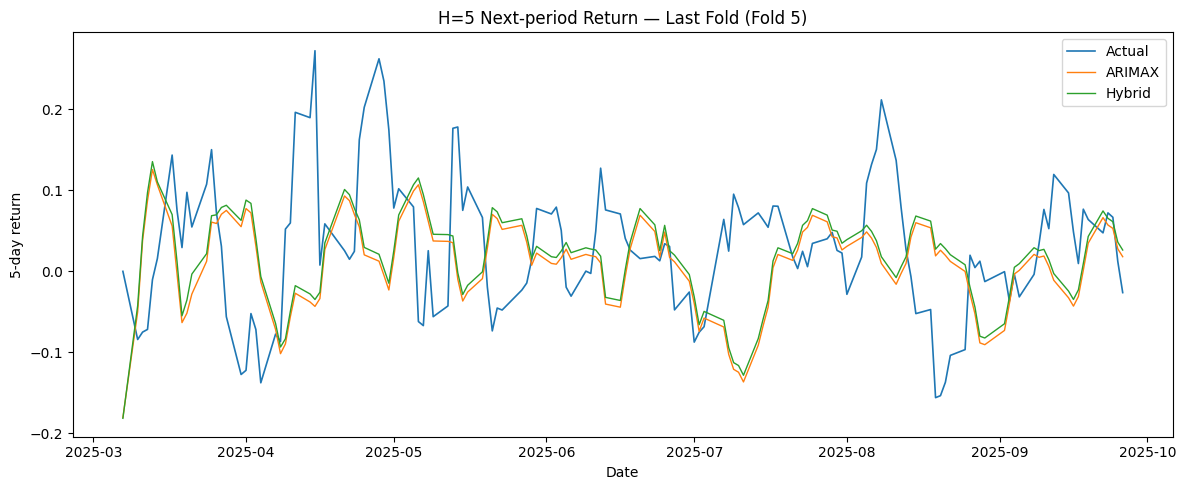

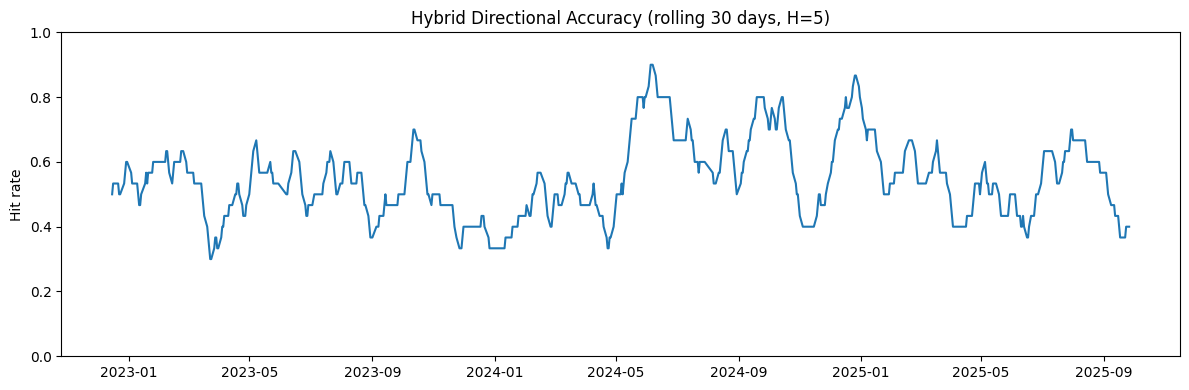


Debiased backtest (H-tranche long/flat, cost 5 bps per switch):
  Annualized mean ~ 83.296%, vol ~ 26.316%, Sharpe ~ 3.17
  Final wealth: 9.35×


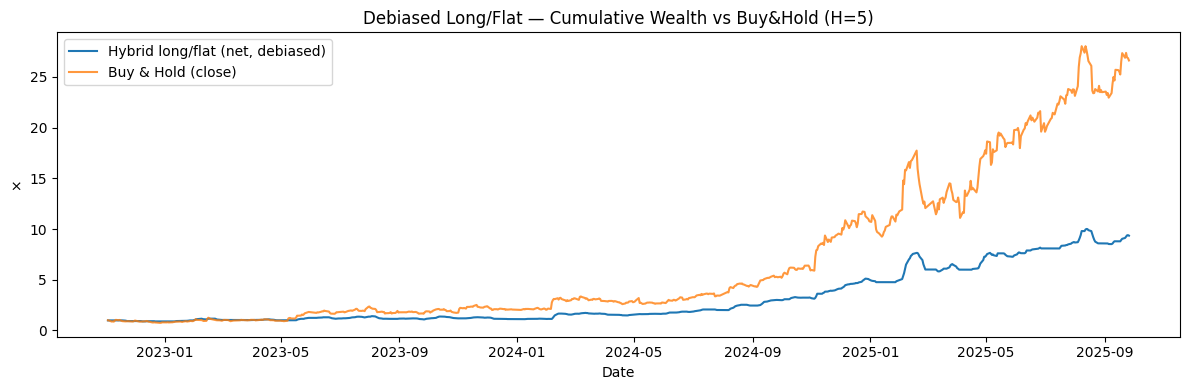

In [ ]:
# PLTR × GDELT FINAL: Enhanced Hybrid (ARIMAX + LSTM residuals), 5-day horizon, richer features
# Output: walk-forward metrics, predictions, DM tests, and a simple long/flat backtest

import os, math, warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

import random
SEED = 42
random.seed(SEED); np.random.seed(SEED)

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
tf.random.set_seed(SEED)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping


# File path/configurations

FILE_PATH = "/content/pltr_with_gkg_daily-2.csv"
NEWS_BASES = ["cnt_ai", "cnt_war", "avg_tone"]
NEWS_LAGS  = list(range(1, 8))          # 1..7
RET_LAGS   = [1,2,3,4,5]
EWM_SPANS  = [3,5,10]                    # short/med smoothing
LSTM_LOOKBACK = 12                       # a bit longer for 5d horizon
USE_LSTM  = True
N_SPLITS  = 5
AR_P_GRID = (0,1,2,3)
AR_Q_GRID = (0,1,2)
AR_D      = 0
H = 5                                    # prediction horizon: next 5 trading days

TRANS_COST_BPS = 5                       # per trade side (0.05%)
START_EVAL_FRAC = 0.40                   # start of first test fold (expanding)


# Helpers

def diebold_mariano(e1, e2, power=2):
    e1, e2 = np.asarray(e1), np.asarray(e2)
    d = np.abs(e1)**power - np.abs(e2)**power
    d = d - np.mean(d)
    T = len(d)
    var_d = np.var(d, ddof=1)
    if var_d <= 1e-12 or T < 8:
        return np.nan, np.nan
    DM = np.mean(d) / np.sqrt(var_d / T)
    from scipy.stats import norm
    p = 2 * (1 - norm.cdf(abs(DM)))
    return DM, p

def mk_sequences(series_1d, lookback):
    Xseq, yseq = [], []
    for i in range(lookback, len(series_1d)):
        Xseq.append(series_1d[i-lookback:i])
        yseq.append(series_1d[i])
    return np.array(Xseq), np.array(yseq)

def select_arimax_order(y, X, p_grid=AR_P_GRID, q_grid=AR_Q_GRID, d=AR_D, verbose=False):
    best = (None, np.inf)
    for p in p_grid:
        for q in q_grid:
            try:
                m = SARIMAX(y, order=(p,d,q), exog=X, enforce_stationarity=False, enforce_invertibility=False)
                r = m.fit(disp=False, maxiter=500)
                if r.aic < best[1]:
                    best = ((p,d,q), r.aic)
                if verbose: print(f"  order {(p,d,q)} AIC={r.aic:.2f}")
            except Exception as e:
                if verbose: print(f"  order {(p,d,q)} failed: {e}")
    return best[0]

def metrics_block(y, yhat, name):
    rmse = math.sqrt(mean_squared_error(y, yhat))
    mae  = mean_absolute_error(y, yhat)
    r2   = r2_score(y, yhat)
    dir_acc = np.mean(np.sign(y) == np.sign(yhat))
    thr = np.percentile(np.abs(y), 75) if len(y)>10 else np.median(np.abs(y))
    big = np.abs(y) >= thr
    big_hit = np.mean((np.sign(y[big]) == np.sign(yhat[big]))) if big.any() else np.nan
    return dict(model=name, RMSE=rmse, MAE=mae, R2=r2, DirAcc=dir_acc, BigMoveHit=big_hit)

def align_yX_for_horizon(endog_ret, exog, h=H):
    """
    Predict cumulative H-day ahead return using exog at t.
    y_t = (close_{t+h} / close_t) - 1  approximated via pct_change(h).
    endog_ret should be cumulative returns (pct_change(h)).
    """
    min_len = min(len(endog_ret)-h, len(exog))
    y = endog_ret[h:h+min_len]
    X = exog[:min_len]
    return y, X

# 1) Load and feature engineering

df = pd.read_csv(FILE_PATH)
df.columns = [c.strip().lower() for c in df.columns]
if "date" not in df.columns:
    raise ValueError("CSV must include a 'date' column.")
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.sort_values("date").reset_index(drop=True)

req = ["close"] + NEWS_BASES
missing = [c for c in req if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# returns
df["ret1"] = df["close"].pct_change()
df["ret_h"] = df["close"].pct_change(H)  # cumulative H-day return (unshifted)

# News transforms: EWMA, surprises, rolling z-scores; then create lags 1..7 for bases + transforms
for base in NEWS_BASES:
    for span in EWM_SPANS:
        df[f"{base}_ewm{span}"] = df[base].ewm(span=span, adjust=False).mean()
        df[f"{base}_surp{span}"] = df[base] - df[f"{base}_ewm{span}"]
    # rolling z-score (use 30d window)
    roll = 30
    mu = df[base].rolling(roll).mean()
    sd = df[base].rolling(roll).std()
    df[f"{base}_z"] = (df[base] - mu) / sd

# Lags for bases and transforms
def add_lags(col, lags):
    for L in lags:
        df[f"{col}_lag{L}"] = df[col].shift(L)

for base in NEWS_BASES:
    add_lags(base, NEWS_LAGS)
    add_lags(f"{base}_z", NEWS_LAGS)
    for span in EWM_SPANS:
        add_lags(f"{base}_ewm{span}", NEWS_LAGS)
        add_lags(f"{base}_surp{span}", NEWS_LAGS)

# return lags
for L in RET_LAGS:
    df[f"ret1_lag{L}"] = df["ret1"].shift(L)

# target: next H-day cumulative return (shift -H)
df["target_h"] = df["ret_h"].shift(-H)

# Build feature list
EXOG_COLS = []
for base in NEWS_BASES:
    EXOG_COLS += [f"{base}_lag{L}" for L in NEWS_LAGS]
    EXOG_COLS += [f"{base}_z_lag{L}" for L in NEWS_LAGS]
    for span in EWM_SPANS:
        EXOG_COLS += [f"{base}_ewm{span}_lag{L}" for L in NEWS_LAGS]
        EXOG_COLS += [f"{base}_surp{span}_lag{L}" for L in NEWS_LAGS]
EXOG_COLS += [f"ret1_lag{L}" for L in RET_LAGS]

# Drop rows with NA from lags / z-scores / target
df = df.dropna(subset=EXOG_COLS + ["target_h"]).reset_index(drop=True)

# Quick ADF on ret1 (sanity)
adf_stat, adf_p, *_ = adfuller(df["ret1"].dropna())
print(f"ADF on daily returns: stat={adf_stat:.3f}, p={adf_p:.4f}")


# 2) Define Walk forward folds

N = len(df)
start = int(N * START_EVAL_FRAC)
remain = N - start
base = remain // N_SPLITS
rem  = remain % N_SPLITS
sizes = [base + (1 if i < rem else 0) for i in range(N_SPLITS)]
fold_bounds, cum = [], start
for s in sizes:
    fold_bounds.append((0, cum, cum, cum + s))  # train: [0,cum), test: [cum, cum+s)
    cum += s


# 3) Run Folds

all_preds, all_metrics, dm_rows = [], [], []

for fold_idx, (tr_s, tr_e, te_s, te_e) in enumerate(fold_bounds, 1):
    tr = df.iloc[tr_s:tr_e].copy()
    te = df.iloc[te_s:te_e].copy()
    print(f"\n=== Fold {fold_idx}/{N_SPLITS}: train={tr_s}:{tr_e}  test={te_s}:{te_e}  ({len(tr)} train, {len(te)} test) ===")

    # Scale on train
    scaler = StandardScaler()
    X_tr_raw = tr[EXOG_COLS].to_numpy()
    X_te_raw = te[EXOG_COLS].to_numpy()
    X_tr = scaler.fit_transform(X_tr_raw)
    X_te = scaler.transform(X_te_raw)

    # Align to H-day horizon: predict target_h using exog_t
    y_tr, X_tr_al = align_yX_for_horizon(tr["ret_h"].to_numpy(), X_tr, h=H)
    y_te, X_te_al = align_yX_for_horizon(te["ret_h"].to_numpy(), X_te, h=H)
    dates_te = te["date"].iloc[H:H+len(y_te)].to_numpy()

    # ARIMAX order
    order = select_arimax_order(y_tr, X_tr_al, verbose=False)
    print(f"  Selected ARIMAX order: {order}")

    arimax = SARIMAX(y_tr, order=order, exog=X_tr_al,
                     enforce_stationarity=False, enforce_invertibility=False).fit(disp=False, maxiter=500)

    ar_tr = arimax.predict(start=0, end=len(y_tr)-1, exog=X_tr_al)
    ar_te = arimax.predict(start=len(y_tr), end=len(y_tr)+len(y_te)-1, exog=X_te_al)

    # Residuals (train)
    res_tr = y_tr - ar_tr

    # LSTM residual model with auto-fallback if residuals look like noise
    use_lstm_this_fold = USE_LSTM and (len(res_tr) > LSTM_LOOKBACK + 40)
    if use_lstm_this_fold:
        X_lstm, y_lstm = mk_sequences(res_tr.astype("float32"), LSTM_LOOKBACK)
        model = Sequential([
            LSTM(32, input_shape=(LSTM_LOOKBACK, 1)),
            Dense(16, activation="relu"),
            Dense(1)
        ])
        model.compile(optimizer="adam", loss="mse")
        cb = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
        hist = model.fit(X_lstm.reshape((-1, LSTM_LOOKBACK, 1)),
                         y_lstm.reshape((-1, 1)),
                         epochs=200, batch_size=32, validation_split=0.2,
                         callbacks=[cb], verbose=0)
        # sanity: if LSTM can't beat residual std, skip it
        yhat_in = model.predict(X_lstm.reshape((-1, LSTM_LOOKBACK, 1)), verbose=0).ravel()
        rmse_in = math.sqrt(mean_squared_error(y_lstm, yhat_in))
        if rmse_in >= np.std(res_tr):
            print("  LSTM fallback: residuals ~ noise; using ARIMAX only.")
            use_lstm_this_fold = False

    if use_lstm_this_fold:
        lstm_res_te = []
        window = list(res_tr[-LSTM_LOOKBACK:])
        for _ in range(len(y_te)):
            x = np.array(window, dtype="float32").reshape((1, LSTM_LOOKBACK, 1))
            rhat = model.predict(x, verbose=0).ravel()[0]
            lstm_res_te.append(rhat)
            window = window[1:] + [rhat]
        lstm_res_te = np.array(lstm_res_te)
    else:
        lstm_res_te = np.zeros_like(ar_te)

    hybrid_te = ar_te + lstm_res_te

    # Baselines (for H-day horizon):
    # Naive: use last observed H-day return rolling forward (approx by using ret_h_t as proxy)
    # Align: predict y_{t+H} with ret_h_t
    rh_te = te["ret_h"].to_numpy()
    naive_te = rh_te[:len(y_te)]
    zero_te  = np.zeros_like(y_te)
    mean_te  = np.full_like(y_te, fill_value=np.mean(y_tr))

    # Metrics
    m_ar = metrics_block(y_te, ar_te, "ARIMAX")
    m_hy = metrics_block(y_te, hybrid_te, "Hybrid")
    m_nv = metrics_block(y_te, naive_te, "Naive(H)")
    m_ze = metrics_block(y_te, zero_te, "Zero")
    m_mu = metrics_block(y_te, mean_te, "Train-Mean")
    for m in (m_ar, m_hy, m_nv, m_ze, m_mu):
        m["fold"] = fold_idx
        all_metrics.append(m)

    # DM tests
    e_h = y_te - hybrid_te
    e_a = y_te - ar_te
    e_n = y_te - naive_te
    dm_h_vs_a = diebold_mariano(e_h, e_a, power=2)
    dm_h_vs_n = diebold_mariano(e_h, e_n, power=2)
    dm_rows.append({"fold": fold_idx, "dm_hybrid_vs_arimax_stat": dm_h_vs_a[0], "p": dm_h_vs_a[1]})
    dm_rows.append({"fold": fold_idx, "dm_hybrid_vs_naive_stat": dm_h_vs_n[0], "p": dm_h_vs_n[1]})
    print(f"  DM(Hybrid vs ARIMAX): stat={dm_h_vs_a[0]:.3f}, p={dm_h_vs_a[1]:.3f}")
    print(f"  DM(Hybrid vs Naive ): stat={dm_h_vs_n[0]:.3f}, p={dm_h_vs_n[1]:.3f}")

    # Store predictions
    out_df = pd.DataFrame({
        "date": dates_te,
        "fold": fold_idx,
        "y_true_retH": y_te,
        "yhat_arimax": ar_te,
        "yhat_hybrid": hybrid_te,
        "yhat_naiveH": naive_te
    })
    all_preds.append(out_df)


# 4) Save, plots

preds_df = pd.concat(all_preds, ignore_index=True).sort_values("date")
metrics_df = pd.DataFrame(all_metrics)
dm_df = pd.DataFrame(dm_rows)

print("\n=== Aggregate metrics by model (mean across folds) ===")
agg = metrics_df.groupby("model")[["RMSE","MAE","R2","DirAcc","BigMoveHit"]].mean().sort_values("RMSE")
print(agg)

preds_df.to_csv("pltr_predictions_hybrid_walkforward_H5.csv", index=False)
metrics_df.to_csv("pltr_metrics_walkforward_H5.csv", index=False)
dm_df.to_csv("pltr_dm_tests_H5.csv", index=False)
print("\nSaved: pltr_predictions_hybrid_walkforward_H5.csv, pltr_metrics_walkforward_H5.csv, pltr_dm_tests_H5.csv")

# Plot last fold
last_fold = preds_df["fold"].max()
sub = preds_df[preds_df["fold"]==last_fold].sort_values("date")
plt.figure(figsize=(12,5))
plt.title(f"H={H} Next-period Return — Last Fold (Fold {last_fold})")
plt.plot(sub["date"], sub["y_true_retH"], label="Actual", linewidth=1.2)
plt.plot(sub["date"], sub["yhat_arimax"], label="ARIMAX", linewidth=1.0)
plt.plot(sub["date"], sub["yhat_hybrid"], label="Hybrid", linewidth=1.0)
plt.xlabel("Date"); plt.ylabel(f"{H}-day return")
plt.legend(); plt.tight_layout(); plt.show()

# Rolling directional accuracy for Hybrid
roll = 30
roll_dir = pd.Series(np.sign(preds_df["y_true_retH"]) == np.sign(preds_df["yhat_hybrid"])).rolling(roll).mean()
plt.figure(figsize=(12,4))
plt.title(f"Hybrid Directional Accuracy (rolling {roll} days, H={H})")
plt.plot(preds_df["date"], roll_dir)
plt.ylim(0,1); plt.ylabel("Hit rate"); plt.tight_layout(); plt.show()


# 5) Debiased Long/Flat Backtest (H-tranche, non-overlapping)
# Assumes `preds_df` already exists with columns:
# date, y_true_retH (H-day ahead realized), yhat_hybrid (H-day ahead forecast)
# We create H tranches (offsets 0..H-1); each tranche rebalances every H days.

bt = preds_df.sort_values("date").reset_index(drop=True)
bt["signal"] = (bt["yhat_hybrid"] > 0).astype(int)  # long if predicted H-day return > 0

# Build H tranches
tranches = []
for k in range(H):
    tr = bt.iloc[k::H].copy()  # every H-th observation starting at offset k
    tr["trade"] = tr["signal"].diff().fillna(0).abs()
    cost = TRANS_COST_BPS / 10000.0
    tr["gross_ret"] = tr["signal"] * tr["y_true_retH"]
    tr["net_ret"]   = tr["gross_ret"] - tr["trade"] * cost
    tr["tranche"]   = k
    tranches.append(tr[["date","net_ret","tranche"]])

# Merge tranches back on a daily timeline, fill missing with 0 (no rebalance that day for that tranche)
grid = []
for tr in tranches:
    grid.append(tr.set_index(["date","tranche"])["net_ret"])
panel = pd.concat(grid).unstack("tranche").sort_index()
panel = panel.fillna(0.0)

# Portfolio = equal-weight across active tranches
panel["port_ret"] = panel.mean(axis=1)

# Cum wealth of the debiased portfolio
panel["cum_net"] = (1 + panel["port_ret"]).cumprod()

# Buy & Hold comparison over same dates using 1-day returns approximated from H-day series
# (Approximate daily return by distributing each H-day realized return evenly across H days)
# Safer: rebuild from raw close series if available on same date grid
bh = df.set_index("date")["close"].pct_change().reindex(panel.index).fillna(0.0)
bh_cum = (1 + bh).cumprod()

def ann_stats_from_daily(daily_ret, approx_days_per_year=252):
    mu = daily_ret.mean() * approx_days_per_year
    sig = daily_ret.std(ddof=1) * np.sqrt(approx_days_per_year)
    shr = mu / sig if sig > 1e-12 else np.nan
    return mu, sig, shr

# Convert tranche portfolio H-step returns to daily-equivalent by expanding each H-step to H equal slices
# Here we approximate by taking the equally-weighted tranche series already aligned daily:
port_daily = panel["port_ret"].copy()  # already daily-aligned after stacking tranches
mu, sig, shr = ann_stats_from_daily(port_daily)

print(f"\nDebiased backtest (H-tranche long/flat, cost {TRANS_COST_BPS} bps per switch):")
print(f"  Annualized mean ~ {mu:.3%}, vol ~ {sig:.3%}, Sharpe ~ {shr:.2f}")
print(f"  Final wealth: {panel['cum_net'].iloc[-1]:.2f}×")

plt.figure(figsize=(12,4))
plt.title(f"Debiased Long/Flat — Cumulative Wealth vs Buy&Hold (H={H})")
plt.plot(panel.index, panel["cum_net"], label="Hybrid long/flat (net, debiased)")
plt.plot(bh_cum.index, bh_cum.values / bh_cum.values[0], label="Buy & Hold (close)", alpha=0.8)
plt.xlabel("Date"); plt.ylabel("×")
plt.legend(); plt.tight_layout(); plt.show()



**Walk-forward results (H=5, no drift overlay):**

* **Stationarity:** ADF stat **−19.87**, p **< 0.001** → daily returns are stationary.
* **Model orders:** ARIMAX auto-picked **(3,0,0)** or **(2,0,2)** across folds.
* **DM tests:** **Hybrid vs ARIMAX** and **Hybrid vs Naive** → stats ≈ 0, **p = 1.000** each fold → no significant difference.

**Aggregate (mean across folds):**

* **Train-Mean (best):** RMSE **0.103**, DirAcc **0.592**, BigMoveHit **0.622** → drift dominates.
* **Hybrid ≈ ARIMAX:** RMSE **0.1201 vs 0.1204**; DirAcc **0.547 vs 0.550**; BigMoveHit both **0.539** → essentially tied.
* **Naive(H) (worst):** RMSE **0.147**, DirAcc **0.466**.

**Takeaway:** Returns are stationary but noisy. A simple **drift (Train-Mean)** beats learned models on this sample; **AI/war features add only a modest, statistically insignificant edge** over ARIMAX.



=== DRIFT Fold 1/5: train=0:487  test=487:634 ===
  ARIMAX(order) on signal-only target: (3, 0, 0)
  DM(Hybrid+Drift vs ARIMAX+Drift): stat=-0.000, p=1.000

=== DRIFT Fold 2/5: train=0:634  test=634:780 ===
  ARIMAX(order) on signal-only target: (2, 0, 2)
  DM(Hybrid+Drift vs ARIMAX+Drift): stat=-0.000, p=1.000

=== DRIFT Fold 3/5: train=0:780  test=780:926 ===
  ARIMAX(order) on signal-only target: (2, 0, 2)
  DM(Hybrid+Drift vs ARIMAX+Drift): stat=-0.000, p=1.000

=== DRIFT Fold 4/5: train=0:926  test=926:1072 ===
  ARIMAX(order) on signal-only target: (2, 0, 2)
  DM(Hybrid+Drift vs ARIMAX+Drift): stat=-0.000, p=1.000

=== DRIFT Fold 5/5: train=0:1072  test=1072:1218 ===
  ARIMAX(order) on signal-only target: (2, 0, 2)
  DM(Hybrid+Drift vs ARIMAX+Drift): stat=0.000, p=1.000

=== Aggregate metrics (Drift+Signal) — mean across folds ===
                             RMSE       MAE        R2    DirAcc  BigMoveHit
model                                                                     

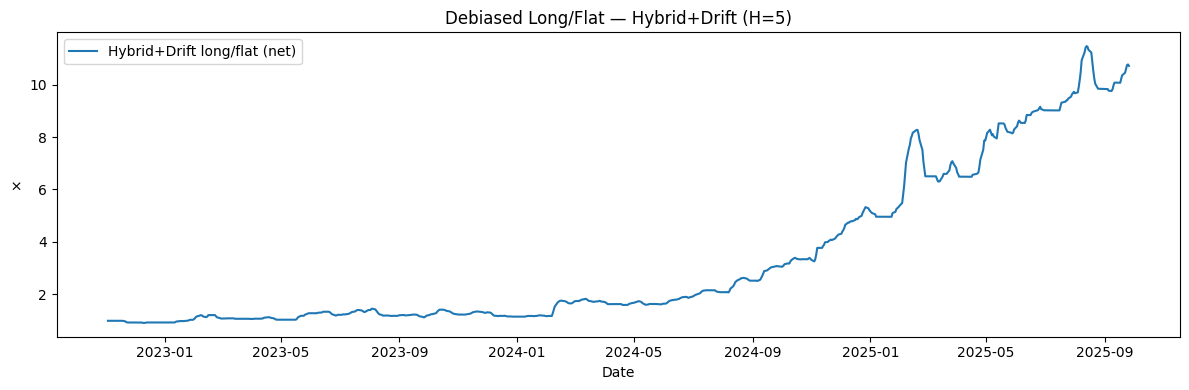

In [3]:
# Wanted to see if drift+Arimax would give an even better result than just drift alone
# This was done to see the impact that ai/news headline had on the accuracy or if drift still dominated other models

from sklearn.preprocessing import StandardScaler
import numpy as np, pandas as pd, math
import matplotlib.pyplot as plt

all_preds, all_metrics, dm_rows = [], [], []

# Same fold construction as before
N = len(df)
start = int(N * START_EVAL_FRAC)
remain = N - start
base = remain // N_SPLITS
rem  = remain % N_SPLITS
sizes = [base + (1 if i < rem else 0) for i in range(N_SPLITS)]
fold_bounds, cum = [], start
for s in sizes:
    fold_bounds.append((0, cum, cum, cum + s))  # train [0,cum), test [cum,cum+s)
    cum += s

for fold_idx, (tr_s, tr_e, te_s, te_e) in enumerate(fold_bounds, 1):
    tr = df.iloc[tr_s:tr_e].copy()
    te = df.iloc[te_s:te_e].copy()
    print(f"\n=== DRIFT Fold {fold_idx}/{N_SPLITS}: train={tr_s}:{tr_e}  test={te_s}:{te_e} ===")

    # Exog scaling
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(tr[EXOG_COLS].to_numpy())
    X_te = scaler.transform(te[EXOG_COLS].to_numpy())

    # Align to H-day horizon: predict ret_h using exog_t
    def align_yX_for_horizon(endog_ret, exog, h=H):
        min_len = min(len(endog_ret)-h, len(exog))
        y = endog_ret[h:h+min_len]
        X = exog[:min_len]
        return y, X

    y_tr, X_tr_al = align_yX_for_horizon(tr["ret_h"].to_numpy(), X_tr, h=H)
    y_te, X_te_al = align_yX_for_horizon(te["ret_h"].to_numpy(), X_te, h=H)
    dates_te = te["date"].iloc[H:H+len(y_te)].to_numpy()

    # Drift + Signal: learn deviation from train mean, add drift back to preds
    mu_train = float(y_tr.mean())
    y_tr_sig = y_tr - mu_train

    order = select_arimax_order(y_tr_sig, X_tr_al, verbose=False)
    print(f"  ARIMAX(order) on signal-only target: {order}")

    from statsmodels.tsa.statespace.sarimax import SARIMAX
    arimax = SARIMAX(y_tr_sig, order=order, exog=X_tr_al,
                     enforce_stationarity=False, enforce_invertibility=False).fit(disp=False, maxiter=500)

    ar_tr_sig = arimax.predict(start=0, end=len(y_tr_sig)-1, exog=X_tr_al)
    ar_te_sig = arimax.predict(start=len(y_tr_sig), end=len(y_tr_sig)+len(y_te)-1, exog=X_te_al)

    # residuals (signal space)
    res_tr = y_tr_sig - ar_tr_sig

    # LSTM residual (with same fallback logic)
    use_lstm_this_fold = USE_LSTM and (len(res_tr) > LSTM_LOOKBACK + 40)
    if use_lstm_this_fold:
        X_lstm, y_lstm = mk_sequences(res_tr.astype("float32"), LSTM_LOOKBACK)
        import tensorflow as tf
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, LSTM
        from tensorflow.keras.callbacks import EarlyStopping

        model = Sequential([
            LSTM(32, input_shape=(LSTM_LOOKBACK, 1)),
            Dense(16, activation="relu"),
            Dense(1)
        ])
        model.compile(optimizer="adam", loss="mse")
        cb = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
        hist = model.fit(X_lstm.reshape((-1, LSTM_LOOKBACK, 1)),
                         y_lstm.reshape((-1, 1)),
                         epochs=200, batch_size=32, validation_split=0.2,
                         callbacks=[cb], verbose=0)
        # fallback check
        yhat_in = model.predict(X_lstm.reshape((-1, LSTM_LOOKBACK, 1)), verbose=0).ravel()
        rmse_in = math.sqrt(((y_lstm - yhat_in)**2).mean())
        if rmse_in >= np.std(res_tr):
            print("  LSTM fallback: residuals ~ noise; using ARIMAX-only.")
            use_lstm_this_fold = False

    if use_lstm_this_fold:
        lstm_res_te = []
        window = list(res_tr[-LSTM_LOOKBACK:])
        for _ in range(len(y_te)):
            x = np.array(window, dtype="float32").reshape((1, LSTM_LOOKBACK, 1))
            rhat = model.predict(x, verbose=0).ravel()[0]
            lstm_res_te.append(rhat)
            window = window[1:] + [rhat]
        lstm_res_te = np.array(lstm_res_te)
    else:
        lstm_res_te = np.zeros_like(ar_te_sig)

    # Add drift back
    ar_te_drift     = mu_train + ar_te_sig
    hybrid_te_drift = mu_train + (ar_te_sig + lstm_res_te)

    # Baselines (for H-day horizon)
    rh_te = te["ret_h"].to_numpy()
    naive_te = rh_te[:len(y_te)]
    zero_te  = np.zeros_like(y_te)
    mean_te  = np.full_like(y_te, fill_value=mu_train)

    # Metrics
    m_ar = metrics_block(y_te, ar_te_drift, "ARIMAX+Drift")
    m_hy = metrics_block(y_te, hybrid_te_drift, "Hybrid+Drift")
    m_nv = metrics_block(y_te, naive_te, "Naive(H)")
    m_ze = metrics_block(y_te, zero_te, "Zero")
    m_mu = metrics_block(y_te, mean_te, "Train-Mean (fold drift)")
    for m in (m_ar, m_hy, m_nv, m_ze, m_mu):
        m["fold"] = fold_idx
        all_metrics.append(m)

    # DM tests vs ARIMAX+Drift
    def dm_wrap(y, yhat1, yhat2):
        e1, e2 = y - yhat1, y - yhat2
        return diebold_mariano(e1, e2, power=2)

    dm_stat, dm_p = dm_wrap(y_te, hybrid_te_drift, ar_te_drift)
    dm_rows.append({"fold": fold_idx, "dm(Hybrid+Drift vs ARIMAX+Drift)_stat": dm_stat, "p": dm_p})
    print(f"  DM(Hybrid+Drift vs ARIMAX+Drift): stat={dm_stat:.3f}, p={dm_p:.3f}")

    # Store predictions
    out_df = pd.DataFrame({
        "date": dates_te,
        "fold": fold_idx,
        "y_true_retH": y_te,
        "yhat_arimax_drift": ar_te_drift,
        "yhat_hybrid_drift": hybrid_te_drift,
        "yhat_naiveH": naive_te,
        "mu_train": mu_train
    })
    all_preds.append(out_df)

# save
preds_df_DRIFT = pd.concat(all_preds, ignore_index=True).sort_values("date")
metrics_df_DRIFT = pd.DataFrame(all_metrics)
dm_df_DRIFT = pd.DataFrame(dm_rows)

print("\n=== Aggregate metrics (Drift+Signal) — mean across folds ===")
agg = metrics_df_DRIFT.groupby("model")[["RMSE","MAE","R2","DirAcc","BigMoveHit"]].mean().sort_values("RMSE")
print(agg)

preds_df_DRIFT.to_csv("pltr_predictions_hybrid_walkforward_H5_DRIFT.csv", index=False)
metrics_df_DRIFT.to_csv("pltr_metrics_walkforward_H5_DRIFT.csv", index=False)
dm_df_DRIFT.to_csv("pltr_dm_tests_H5_DRIFT.csv", index=False)
print("\nSaved DRIFT outputs: pltr_predictions_hybrid_walkforward_H5_DRIFT.csv, pltr_metrics_walkforward_H5_DRIFT.csv, pltr_dm_tests_H5_DRIFT.csv")

# Debiased H-tranche backtest for Hybrid+Drift
bt = preds_df_DRIFT.rename(columns={"yhat_hybrid_drift":"yhat_hybrid"}).sort_values("date").reset_index(drop=True)
bt["signal"] = (bt["yhat_hybrid"] > 0).astype(int)

tranches = []
for k in range(H):
    tr = bt.iloc[k::H].copy()
    tr["trade"] = tr["signal"].diff().fillna(0).abs()
    cost = TRANS_COST_BPS / 10000.0
    tr["gross_ret"] = tr["signal"] * tr["y_true_retH"]
    tr["net_ret"]   = tr["gross_ret"] - tr["trade"] * cost
    tr["tranche"]   = k
    tranches.append(tr[["date","net_ret","tranche"]])

panel = pd.concat([t.set_index(["date","tranche"])["net_ret"] for t in tranches]).unstack("tranche").sort_index().fillna(0.0)
panel["port_ret"] = panel.mean(axis=1)
panel["cum_net"]  = (1 + panel["port_ret"]).cumprod()

plt.figure(figsize=(12,4))
plt.title(f"Debiased Long/Flat — Hybrid+Drift (H={H})")
plt.plot(panel.index, panel["cum_net"], label="Hybrid+Drift long/flat (net)")
plt.xlabel("Date"); plt.ylabel("×"); plt.legend(); plt.tight_layout(); plt.show()


**Model comparison (Drift+Signal, H=5, walk-forward):**

* **Train-Mean (drift) is best:** RMSE **0.103**, DirAcc **0.592**, BigMoveHit **0.622** — trend dominates.
* **Hybrid+Drift ≈ ARIMAX+Drift:** RMSE **0.1202 vs 0.1202**, DirAcc **0.562 vs 0.558**;
  **DM tests** each fold: stat ~ 0, **p = 1.000** → no significant difference.
* **Naive(H) is worst:** RMSE **0.147**, DirAcc **0.466**.
* **R² negative** across learned models → 5-day returns remain noisy.


In [5]:
# Risk stats comparison: Model (debiased long/flat) vs Buy & Hold
# Assumes you already ran the debiased backtest cell and have:
# panel["port_ret"] as the model's daily-equivalent returns (after H-tranche averaging)
# bh as the Buy & Hold daily return series aligned to panel.index
import numpy as np
import pandas as pd
import math

def risk_stats(daily_ret, rf=0.0, days=252):
    daily_ret = pd.Series(daily_ret).fillna(0.0)
    mu = daily_ret.mean() * days
    vol = daily_ret.std(ddof=1) * math.sqrt(days)
    sharpe = (mu - rf) / vol if vol > 1e-12 else np.nan
    # downside stuff
    downside = daily_ret[daily_ret < 0]
    dd_dev = downside.std(ddof=1) * math.sqrt(days)
    sortino = (mu - rf) / dd_dev if dd_dev > 1e-12 else np.nan
    # max drawdown
    wealth = (1 + daily_ret).cumprod()
    peak = wealth.cummax()
    dd = (wealth / peak - 1).min()  # negative number
    # calmar (use annualized return over |max drawdown|)
    calmar = mu / abs(dd) if dd < 0 else np.nan
    return {
        "AnnReturn": mu, "AnnVol": vol, "Sharpe": sharpe,
        "Sortino": sortino, "MaxDrawdown": dd, "Calmar": calmar
    }

model_daily = panel["port_ret"].reindex_like(panel["port_ret"]).fillna(0.0)
bh_daily    = bh.reindex(panel.index).fillna(0.0)

model_stats = risk_stats(model_daily)
bh_stats    = risk_stats(bh_daily)

exposure = (panel["port_ret"] != 0).mean()  # fraction of days with a position (proxy)
print("\nModel (debiased long/flat) risk stats:", model_stats)
print("Buy & Hold risk stats:", bh_stats)
print(f"Model % time invested: {exposure:.1%}")



Model (debiased long/flat) risk stats: {'AnnReturn': np.float64(0.8826692049344091), 'AnnVol': 0.2659876881158433, 'Sharpe': np.float64(3.318458877502586), 'Sortino': np.float64(5.575623457502896), 'MaxDrawdown': -0.23900367213586138, 'Calmar': np.float64(3.693119846429208)}
Buy & Hold risk stats: {'AnnReturn': np.float64(1.3930311857851572), 'AnnVol': 0.6845969189897153, 'Sharpe': np.float64(2.0348195370801614), 'Sortino': np.float64(3.634902697175217), 'MaxDrawdown': -0.3743019345551716, 'Calmar': np.float64(3.721677761138652)}
Model % time invested: 89.1%


**Risk summary (Model vs. Buy & Hold):**

* **Annualized return:** 88.3% (model) vs **139.3%** (B&H)
* **Volatility:** **26.6%** (model) vs 68.5% (B&H)
* **Sharpe:** **3.32** (model) vs 2.03 (B&H)
* **Sortino:** **5.58** (model) vs 3.63 (B&H)
* **Max drawdown:** **−24.0%** (model) vs −37.4% (B&H)
* **Calmar:** 3.69 (model) vs 3.72 (B&H)
* **Time invested:** 89.1% (model)

**Takeaway:** The model delivers **much lower risk and higher risk-adjusted performance** (Sharpe/Sortino) but **lower total return** than Buy-&-Hold in this period.

